In [409]:


# load dependencies
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import PrecisionRecallDisplay
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import ConfusionMatrixDisplay
from mapie.utils import train_conformalize_test_split
from mapie.classification import SplitConformalClassifier
from mapie.metrics.classification import classification_coverage_score
import shap
import pickle


In [364]:
# Load data
df = pd.read_csv('../data/clean/alzheimers.csv')
df.head()

,ADL,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,Diagnosis
0,-1.104434,0.779037,0.497506,0,0,0
1,-0.810601,0.680297,0.704907,0,0,0
2,0.724491,-0.859222,0.281813,0,0,0
3,0.508044,-0.088723,1.343346,0,1,0
4,-1.684679,-0.143712,0.333665,0,0,0


In [365]:
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

Conformalizing model predictions to get prediction sets using MAPIE

Set train, conformalize and test sets, 80-10-10

In [366]:
(X_train, X_cal, X_test, y_train, y_cal, y_test) = (
    train_conformalize_test_split(
        X, y, train_size=0.8, conformalize_size=0.1, test_size=0.1
    )
)

In [367]:
# Create and Fit Model
model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### Probability Calibration

The goal of probability calibration is to calibrate the probabilities of the model to be reflective of real world frequencies. This can be directly interpreted as a confidence level or a reported risk of Alzheimers.

CalibratedClassifierCV from scikit-learn for calibrating probabilities using cross validation on the training set.

In [391]:
rf = RandomForestClassifier(random_state=42)

model_cal = CalibratedClassifierCV(estimator=rf, cv=5, method='sigmoid')

model_cal.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,method,'sigmoid'
,cv,5
,n_jobs,None
,ensemble,'auto'
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


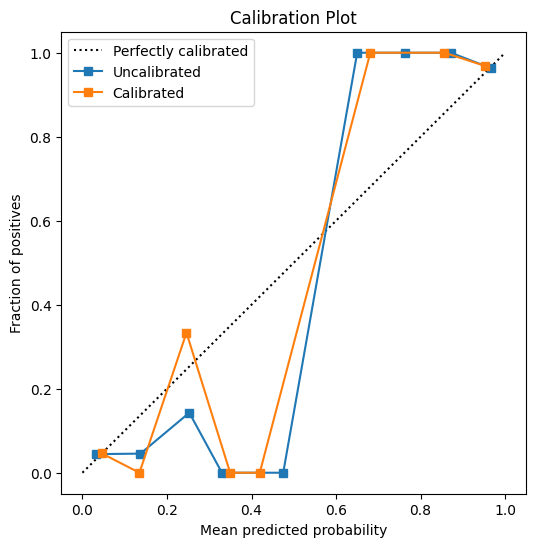

In [392]:
fig, ax = plt.subplots(figsize=(6, 6))

# Default calibration curve (base model)
CalibrationDisplay.from_estimator(
    model,
    X_test, y_test,
    n_bins=10,
    strategy="uniform",
    name="Uncalibrated",
    ax=ax
)

# calibrated curve (model_cal)
CalibrationDisplay.from_estimator(
    model_cal,
    X_test, y_test,
    n_bins=10,
    strategy="uniform",
    name="Calibrated",
    ax=ax
)

ax.set_title("Calibration Plot")
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Fraction of positives")
ax.legend(loc="best")
plt.show()


#### MAPIE Conformalization

After calibrating the probabilities, we use the calibrated classifier to get the prediction sets using the "lac" conformity score which is 1 - P^(y|X). This would in turn create more confidence in the prediction sets for where the true label lies.

In [396]:
# 90% coverage
confidence_level = 0.90

# Use the calibrated classifier
mapie_conformal = SplitConformalClassifier(
    estimator=model_cal, confidence_level=confidence_level, prefit=True
)

mapie_conformal.conformalize(X_cal, y_cal)

y_pred, y_pred_set = mapie_conformal.predict_set(X_test)

y_pred is a numpy array of predicted values and y_pred_set is a list of sets of predicted values that cover the true value with a 90% confidence.

#### Model Metrics/Performance

In [397]:
coverage_score = classification_coverage_score(y_test, y_pred_set)
print(
    f"For a confidence level of {confidence_level:.2f}, "
    f"the target coverage is {confidence_level:.3f}, "
    f"and the effective coverage is {coverage_score[0]:.3f}."
)

For a confidence level of 0.90, the target coverage is 0.900, and the effective coverage is 0.935.


This means that the confidence level of 90% is met by our model

In [398]:
set_sizes = y_pred_set.sum(axis=1)
print("Average set size:", set_sizes.mean())
print("Singleton rate:", (set_sizes == 1).mean())
print("Ambiguous rate:", (set_sizes > 1).mean())
print("Empty rate:", (set_sizes == 0).mean())

Average set size: 0.9722222222222222
Singleton rate: 0.9722222222222222
Ambiguous rate: 0.0
Empty rate: 0.027777777777777776


Calibrated Probability (P(y=1 | x) vs Prediction Set Size

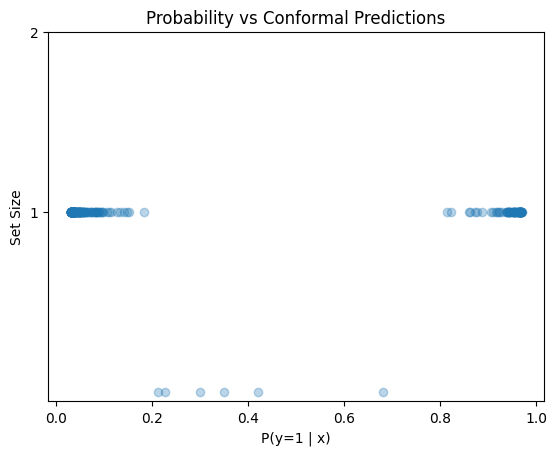

In [406]:
probs = model_cal.predict_proba(X_test)[:, 1]

plt.scatter(probs, set_sizes, alpha=0.3)
plt.xlabel("P(y=1 | x)")
plt.ylabel("Set Size")
plt.yticks([1, 2])
plt.title("Probability vs Conformal Predictions")
plt.show()

A very small amount of sets have no elements and the probabilities vary and they range from 0.2-0.8 roughly. The singleton sets have high and low probabilities associated with them which makes sense. Low probabilities are likely {0} and high probabilities are most likely {1}.

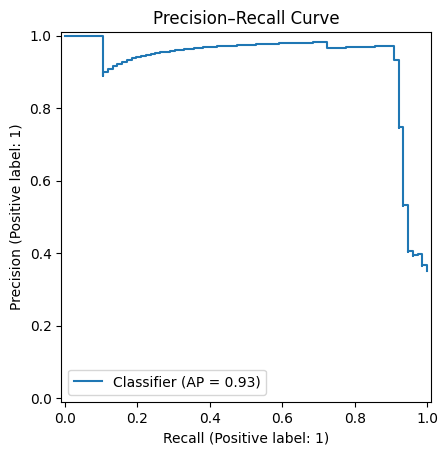

In [410]:
y_proba = model_cal.predict_proba(X_test)[:, 1]
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title("Precision–Recall Curve")
plt.show()

Model Classification Report

In [401]:
# testing model performance
predictions = model_cal.predict(X_test)

print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       140
           1       0.97      0.91      0.94        76

    accuracy                           0.96       216
   macro avg       0.96      0.95      0.95       216
weighted avg       0.96      0.96      0.96       216

0.9583333333333334


##### Confusion Matrix
Making predictions and creating a confusion matrix with a threshold of 0.7

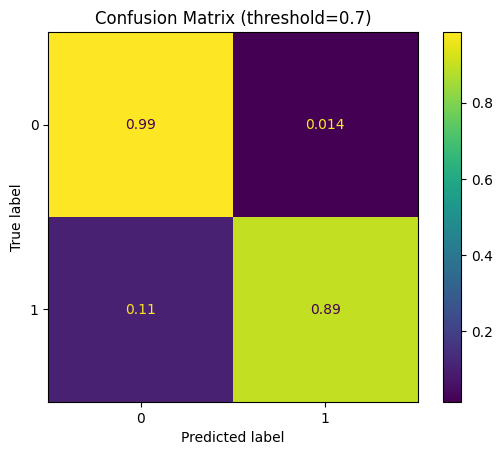

In [374]:
y_proba = model_cal.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.7).astype(int)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true")
plt.title("Confusion Matrix (threshold=0.7)")
plt.show()

Normal Confusion Matrix

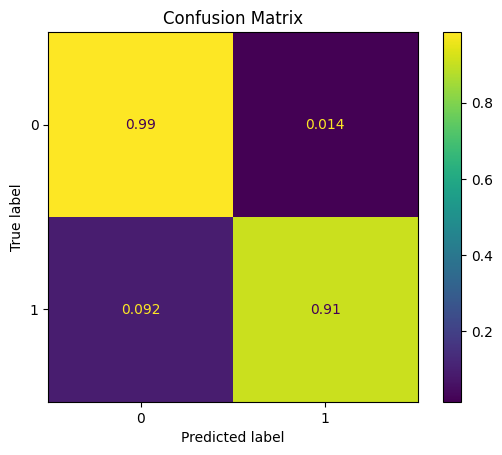

In [375]:
y_pred  = model_cal.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true")
plt.title("Confusion Matrix")
plt.show()

From these matrices, we can see that our model is better at predicting the absence of Alzheimer's than the presence. This is likely due to the higher number of data points that contain no Alzheimer's as the diagnosis. Our model is more prone to false negatives than false positives.

### SHAP Explanations

In [376]:
# Create a sample dataset from our training data
# This step reduces computation burden while maximizing results due to CLT
# It is not fully necessary, but is good practice when dealing with large datasets
X_background = X_train.sample(100, random_state=42)

In [377]:
# SHAP values with TreeExplainer (Base Model)
explainer = shap.TreeExplainer(model, X_background)
shap_values = explainer(X_test)

#### SHAP Values of Uncalibrated Model

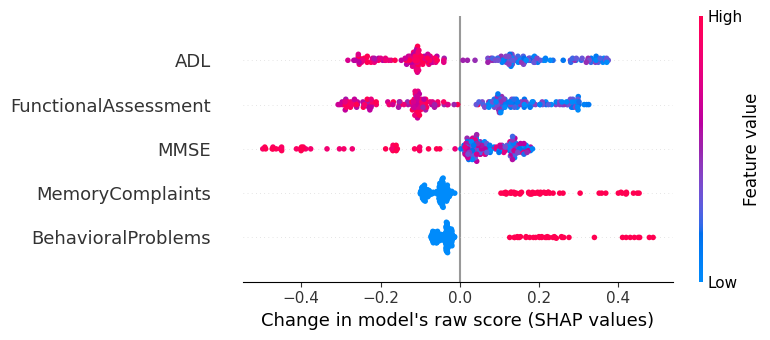

In [378]:
shap.summary_plot(
    shap_values[..., 1],
    X_test,
    feature_names=X_test.columns,
    show=False
)
plt.xlabel("Change in model's raw score (SHAP values)")
plt.show()

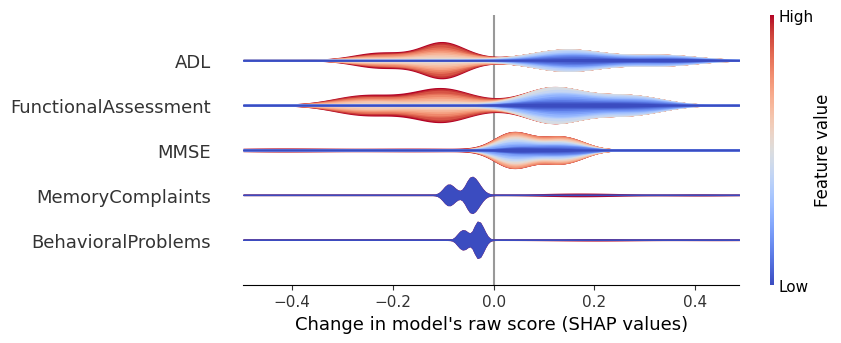

In [379]:
# violin plot of shap values
shap.plots.violin(shap_values[..., 1], plot_type="layered_violin", show=False)
plt.xlabel("Change in model's raw score (SHAP values)")
plt.show()

### Interpreting plots (Uncalibrated model)

##### Functional Assessment
Higher scores on the assessment correspond to a lower model score while lower assessment scores correspond to higher model score of Alzheimer's. 

##### Active Daily Living Assessment
Similar contributions as the Functional Assessment

##### Mini Mental State Assessment
Positive contributions to the model's score from both high and low values, but not by much. More low values contribute to a higher model score. As seen in the summary plot, High scores on the MMSE have a negative contribution to the model's score away from Alzheimer's.

##### Memory Complaints and Behavioral Problems
The absence of memory complaints and behavioral problems have a small negative contribution to the model's score, while the presence of these issues have a large positive influence on the model score. There are a higher number of data points without these issues than there are with these issues.

#### SHAP Values of Calibrated Model (Reported Risk/Confidence in Prediction)

In [380]:
# Explainer with CalibratedClassifierCV
explainer = shap.Explainer(model_cal.predict_proba, X_background)
shap_values_cal = explainer(X_test)

ExactExplainer explainer: 217it [00:11,  2.61it/s]                         


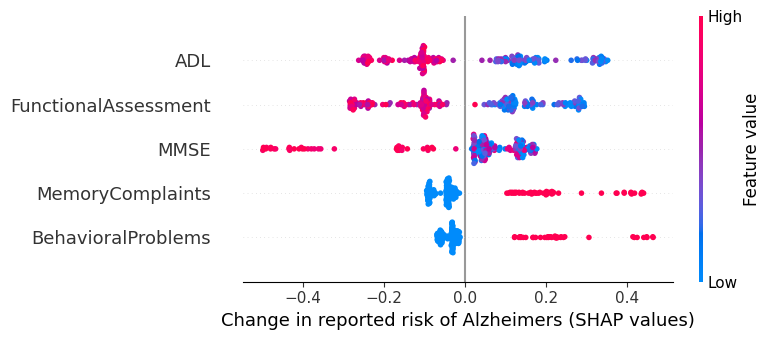

In [381]:
shap.summary_plot(
    shap_values_cal[..., 1],
    X_test,
    feature_names=X_test.columns,
    show=False
)
plt.xlabel("Change in reported risk of Alzheimers (SHAP values)")
plt.show()

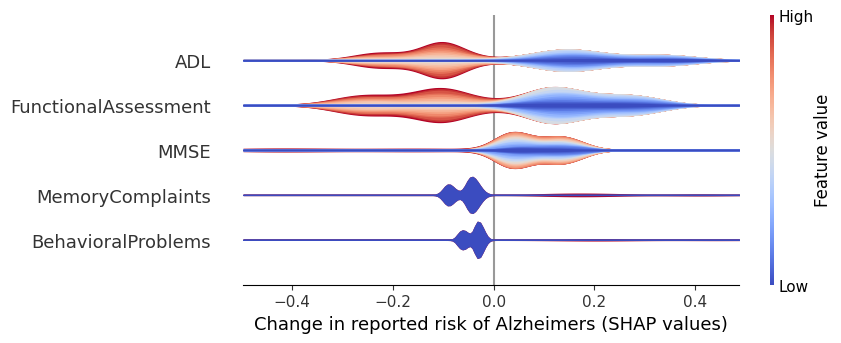

In [382]:
# violin plot of shap values
shap.plots.violin(shap_values[..., 1], plot_type="layered_violin", show=False)
plt.xlabel("Change in reported risk of Alzheimers (SHAP values)")
plt.show()

### Interpreting plots (Calibrated model)

##### Functional Assessment
High and intermediate scores on the assessment lead to a lower reported risk of Alzheimer's. Low Scores indicate a higher reported risk of Alzheimer's according to the model.

##### Active Daily Living Assessment
Similar reported risk observations as the Functional Assessment.

##### Mini Mental State Assessment
As seen in the summary plot, High scores on the MMSE lead to a lower reported risk of Alzheimer's. As seen in the summary plot, MMSE influences model predictions, but does not show a strong monotonic relationship with increased reported risk of Alzheimer's. This might indicate that MMSE is context dependent.

##### Memory Complaints and Behavioral Problems
The absence of memory complaints and behavioral problems have a small decrease in reported risk of Alzheimer's. The presence of these issues has a large increase in reported risk of Alzheimer's. There are a higher number of data points without these issues than there are with these issues.

##### Packaging Models

In [383]:
with open('../models/base_rf.pkl', 'wb') as f:
  pickle.dump(model, f)

In [384]:
with open('../models/cal_rf.pkl', 'wb') as f:
  pickle.dump(model_cal, f)

In [385]:
with open('../models/mapie_rf.pkl', 'wb') as f:
  pickle.dump(mapie_conformal, f)

##### Saving Data Partitions

In [411]:
# Data Partitions as a CSV
X_train.to_csv('../data/partitions/X_train.csv', index=False)
X_cal.to_csv('../data/partitions/X_cal.csv', index=False)
X_test.to_csv('../data/partitions/X_test.csv', index=False)
y_train.to_csv('../data/partitions/y_train.csv', index=False)
y_cal.to_csv('../data/partitions/y_cal.csv', index=False)
y_test.to_csv('../data/partitions/y_test.csv', index=False)